<h2 id="anexoh" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO H - ENTRENAMIENTO Y EVALUACIÓN - RED NEURONAL RECURRENTE PARTE II</h2>

### CARGA DE LIBRERIAS

In [1]:
!pip install keras_tuner

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import pickle
import random
import time

#Sklearn
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GroupKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#Keras
import keras_tuner as kt
from keras_tuner import HyperParameters, HyperModel
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import Hyperband


<ipython-input-5-a3742323ed42>:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


### CARGA DE DATOS - LOCAL

In [ ]:
path = "./CMaps/"
train_doc = "train_FD004.txt"
test_doc = "test_FD004.txt"
test_target_doc="RUL_FD004.txt"

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

#Leer los datos
train = pd.read_csv((path+train_doc), sep="\s+", header=None,
                 names=col_nombres)
test = pd.read_csv((path+test_doc), sep="\s+", header=None,
                 names=col_nombres)
y_test = pd.read_csv((path+test_target_doc), sep="\s+", header=None,
                 names=["RUL"])

### CARGA DE DATOS - COLAB

In [6]:
from google.colab import drive
drive.mount("/content/drive")

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

#Leer los datos

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/train_FD004.txt", sep="\s+", header=None, names=col_nombres)
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/test_FD004.txt", sep="\s+", header=None, names=col_nombres)
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/RUL_FD004.txt", sep="\s+", header=None, names=["RUL"])

Mounted at /content/drive


### FUNCIONES AUXILIARES

In [7]:
def RUL_add(dataframe,clipped=False,early=None):
    if "unit_num" in dataframe.columns and "cycle" in dataframe.columns:

        df_rul=dataframe.groupby("unit_num")["cycle"].max().reset_index()
        df_rul.columns=["unit_num","max"]
        dataframe = pd.merge(dataframe, df_rul, on="unit_num")
        dataframe["RUL"]=dataframe["max"]-dataframe["cycle"]
        dataframe=dataframe.drop(labels="max",axis=1)

        if clipped:
             dataframe["RUL"]=dataframe["RUL"].clip(upper=early)

        return dataframe
    else:
        print("El dataframe debe contener las columnas unit_num y cycle")

In [8]:
#Función individual: a aplicar para cada "unit_num"
def Crear_Secuencias_X(df,ventana,columnas):
    data=df[columnas].copy()
    observaciones=data.shape[0]

    desde=range(0,observaciones-(ventana-1))
    hasta=range(ventana,observaciones+1)

    for i,j in zip(desde,hasta):
        yield data.iloc[i:j,].values

def Crear_Secuencias_y(df,ventana,columnas):
    data=df[columnas].copy()
    observaciones=data.shape[0]
    return data.iloc[ventana-1:observaciones,].values

#Función para aplicar a todo el dataframe
def Crear_Secuencias_X_total(df,ventana,columnas):
    array=(list(Crear_Secuencias_X(df[df["unit_num"]==i],ventana,columnas)) for i in df["unit_num"].unique())
    array=np.concatenate(list(array)).astype(np.float32)
    return array

def Crear_Secuencias_y_total(df,ventana,columnas):
    array=[Crear_Secuencias_y(df[df["unit_num"]==i],ventana,columnas) for i in df["unit_num"].unique()]
    array=np.concatenate(list(array)).astype(np.float32)
    return array


In [9]:
def Crear_Secuencias_X_test(df,ventana,columnas,padding_num):
    data=df.copy()
    observaciones=data.shape[0]

    if observaciones < ventana:
        dif=ventana-observaciones
        array = np.full((ventana, len(columnas)), padding_num)
        array = np.vstack((array[:dif, :], data[col_x].values))
    else:
        array=data[columnas].values

    yield array[array.shape[0]-ventana:array.shape[0],:]

### PROCESAMIENTO DE DATOS

In [10]:
train["setting_1"]=train["setting_1"].round(decimals=1)
train["setting_2"]=train["setting_2"].round(decimals=2)

test["setting_1"]=test["setting_1"].round(decimals=1)
test["setting_2"]=test["setting_2"].round(decimals=2)

In [11]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num

y_train=X_train[["unit_num","RUL"]] #Se adiciona unit_num para implementar la generación de secuencias por unidad (motor)
X_train=X_train.drop(labels=["RUL","cycle"],axis=1) # Se mantiene "unit_num"  para implementar la generación de secuencias por unidad (motor)

#Test
X_test=test.drop(labels=["cycle"],axis=1)#no saco "unit_num"  para implementar la generación de secuencias por unidad (motor)

#Se crea variable condición operativa
X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                        X_train["setting_2"].astype(str) + "_" + \
                        X_train["setting_3"].astype(str)

X_test["condición_op"] = X_test["setting_1"].astype(str) + "_" + \
                        X_test["setting_2"].astype(str) + "_" + \
                        X_test["setting_3"].astype(str)


#Escalado por condición operativa
for cond in X_train["condición_op"].unique():
    filtro=X_train[X_train["condición_op"]==cond]
    filtro_test=X_test[X_test["condición_op"]==cond]
    scaler = MinMaxScaler()
    scaler.fit(filtro[sensor])
    X_train.loc[X_train["condición_op"]==cond, sensor]=scaler.transform(filtro[sensor])
    X_test.loc[X_test["condición_op"]==cond, sensor]=scaler.transform(filtro_test[sensor])



#Se eliminan las 3 variables setting y se crean variables dummies para la variable condición operativa
X_train=X_train.drop(labels=settings,axis=1)
X_test=X_test.drop(labels=settings,axis=1)


X_train=pd.get_dummies(data=X_train,columns=["condición_op"])
X_test=pd.get_dummies(data=X_test,columns=["condición_op"])

#Eliminación de variables no seleccionadas durante el FE.
sensores_a_eliminar = ["s_1", "s_5", "s_18", "s_19","s_10"]
X_train=X_train.drop(labels=sensores_a_eliminar,axis=1)
X_test=X_test.drop(labels=sensores_a_eliminar,axis=1)
sensor = list(set(sensor) - set(sensores_a_eliminar))

print(f"Tamaño X_train = {X_train.shape} y Tamaño y_train = {y_train.shape}\nTamaño X_test {X_test.shape} y Tamaño y_test {y_test.shape}")

Tamaño X_train = (61249, 23) y Tamaño y_train = (61249, 2)
Tamaño X_test (41214, 23) y Tamaño y_test (248, 1)


###  CREACIÓN DE SECUENCIAS
Con las funciones previamente definidas y para el tamaño de ventana seleccionado, se crearon las secuencias tanto para el conjunto de entrenamiento como para el conjunto de validación.

In [ ]:
ventana=30

#Semilla
seed=42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

In [ ]:
#Se aplica group shuffle split para separar en train/validation set
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
for train_indices, val_idices in gss.split(X_train,y_train,groups=groups):
    X_train_split, X_val_split = X_train.iloc[train_indices],X_train.iloc[val_idices]
    y_train_split, y_val_split =y_train.iloc[train_indices],y_train.iloc[val_idices]

col_x = list(set(X_train.columns) - set(["unit_num"]))
col_y = ["RUL"]
num_features = len(col_x)

X_train_array = Crear_Secuencias_X_total(X_train_split, ventana=ventana, columnas=col_x)
X_val_array = Crear_Secuencias_X_total(X_val_split, ventana=ventana, columnas=col_x)
y_train_array = Crear_Secuencias_y_total(y_train_split, ventana=ventana, columnas=col_y)
y_val_array = Crear_Secuencias_y_total(y_val_split, ventana=ventana, columnas=col_y)

print(X_train_array.shape)
print(X_val_array.shape)

(46317, 30, 22)
(7711, 30, 22)


### AJUSTE DE HIPERPARÁMETROS
En esta etapa, nos adentraremos en el proceso crucial de ajuste de hiperparámetros, el cual desempeña un papel fundamental para optimizar el rendimiento del modelo. Hasta ahora, hemos definido el tamaño de ventana y la arquitectura de la red, pero todavía no hemos explorado el impacto de los hiperparámetros en los resultados del modelo. En el contexto de redes neuronales, los principales parámetros a explorar son la función de activación y el número de neuronas en cada capa.
- La **función de activación** define cómo las neuronas se "activan", permitiendo la captura de patrones complejos en los datos.
- El **número de neuronas** en cada capa influye en la capacidad y complejidad de la red para aprender relaciones relevantes.

Asimismo, existen hiperparámetros vinculados a la optimización, en particular, la tasa de aprendizaje (learning rate) y el tamaño de lote (batch size).
- La **tasa de aprendizaje** determina el tamaño de los pasos que la red toma durante el proceso de optimización, influyendo en la rapidez y precisión de la convergencia.
- El **tamaño de lote** afecta la cantidad de muestras de entrenamiento utilizados para calcular la función de pérdida antes de actualizar los pesos de la red, influyendo en la eficiencia y la variabilidad.

Por último, es relevante destacar que, si bien las redes neuronales tienen un gran potencial para capturar patrones complejos en los datos, lo que explica en gran medida su eficacia, también poseen una propensión alta al sobreajuste. Esto se debe a su capacidad para ajustarse en exceso a los detalles ruidosos de los datos de entrenamiento, lo que puede resultar en un rendimiento deficiente en datos no vistos.

Para abordar esta problemática, surgen las técnicas de regularización. Estas estrategias buscan contrarrestar el sobreajuste al introducir ciertas restricciones en la red neuronal durante el proceso de aprendizaje. En este trabajo se utilizaron dos técnicas de regularización: el dropout y la parada temprana (early stopping). La técnica de dropout desactiva selectivamente neuronas durante el entrenamiento, evitando el sobreajuste y promoviendo la generalización. La detención temprana monitoriza la pérdida en el conjunto de validación y detiene el entrenamiento cuando los signos de sobreajuste se vuelven evidentes.

Al introducir dropout se deba ajustar también el hiperparámetro de dropout_rate:
- El **dropout_rate** especifica la proporción de neuronas que se desactivarán temporalmente en cada paso de entrenamiento.

**ESTRATEGIA DE AJUSTE**  
Para el ajuste de hiperparámetros se utilizó KerasTuner, un marco de optimización de hiperparámetros dentro de Keras. Para ello, en una primera instancia se definió una clase llamada MyHypermodel, que servirá para construir y entrenar diferentes variantes del modelo con distintos hiperparámetros. Dentro se establecieron rangos y valores iniciales para cada hiperparámetro, y se definió la arquitectura del modelo previamente seleccionado.

Finalmente se utiliza uno de los algoritmos de optimización disponibles, en particular, Hyperband. Durante la búsqueda, el modelo se entrena con diferentes combinaciones de hiperparámetros utilizando el conjunto de entrenamiento y se evalúa su rendimiento en el conjunto de validación. Hyperband es una técnica avanzada para ajustar los hiperparámetros de manera eficiente. En lugar de probar todas las combinaciones posibles de hiperparámetros, Hyperband divide los recursos disponibles en "bandas" y prueba varias configuraciones en paralelo. Descarta rápidamente las combinaciones menos prometedoras y asigna más recursos a las más prometedoras. Esto permite identificar de manera más rápida y eficiente la mejor combinación de hiperparámetros que optimiza el rendimiento del modelo.


In [ ]:
# Clase para construir el modelo con hiperparámetros ajustables
class MyHypermodel(kt.HyperModel):
    def build(self,hp):
        dropout_rate = hp.Float("dropout", 0.0, 0.5, step=0.1, default=0.2)  
        learning_rate = hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2], default=1e-3) 
        activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"], default="relu")
        neuronas_L1=hp.Int("neuronas_L1", 32, 256, step=32, default=64)
        neuronas_L2=hp.Int("neuronas_L2", 32, 256, step=32, default=64)
        neuronas_L3=hp.Int("neuronas_L3", 32, 256, step=32, default=64)
        neuronas_D=hp.Int("neuronas_D", 32, 128, step=32, default=64)

        #Modelo
        inputs = Input(shape=(ventana, num_features))
        mask = Masking(mask_value=-99.)(inputs)
        lstm_1 = LSTM(units=neuronas_L1,activation=activation,return_sequences=True)(mask)
        drop_1=Dropout(dropout_rate)(lstm_1)
        lstm_2=LSTM(units=neuronas_L2,activation=activation,return_sequences=True)(drop_1)
        drop_2=Dropout(dropout_rate)(lstm_2)
        lstm_3=LSTM(units=neuronas_L3,activation=activation,return_sequences=False)(drop_2)
        drop_3=Dropout(dropout_rate)(lstm_3)
        dense_1=Dense(neuronas_D)(drop_3)
        output = Dense(1)(dense_1)

        model = Model(inputs=inputs, outputs=output)

        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss="mean_squared_error", optimizer=optimizer)

        return model

    def fit(self,hp,model,*args,**kwargs):
        batch_size = hp.Choice("batch_size", [16, 32, 64, 128,256])
        return model.fit(*args,batch_size=batch_size,**kwargs)

directorio="/content/drive/MyDrive/Colab Notebooks/TFM/KERASTUNER_HYPERBAND"

#Crear instancia de Hyperband para buscar hiperparámetros
tuner = Hyperband(
    MyHypermodel(),
    objective="val_loss",
    max_epochs=30,
    factor=3,
    seed=seed,
    directory=directorio,
    project_name="my_project_tuner_hyperband",
    overwrite=False
)

#Ejecutar búsqueda de hiperparámetros
tuner.search(X_train_array, y_train_array,
             validation_data=(X_val_array,y_val_array),
             epochs=30,
             callbacks=[EarlyStopping(patience=5), ModelCheckpoint("best_model.h5", save_best_only=True)],
             verbose=1)

Trial 90 Complete [00h 13m 29s]
val_loss: 1747.733154296875

Best val_loss So Far: 275.6338195800781
Total elapsed time: 11h 42m 46s


A continuación se pueden observar los mejores hiperparámetros obtenidos:

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0].values

print("Mejores hiperparámetros encontrados:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Mejores hiperparámetros encontrados:
dropout: 0.0
learning_rate: 0.001
activation: sigmoid
neuronas_L1: 128
neuronas_L2: 160
neuronas_L3: 64
neuronas_D: 64
batch_size: 16
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0074


### ANÁLISIS DROPOUT
Según los resultados del ajuste de hiperparámetros, se observa que el mejor rendimiento se alcanza cuando no se aplica la técnica de Dropout. No obstante, es importante tener en cuenta que la validación se realizó de manera integral, utilizando una misma tasa de dropout para todas las capas. Esto significa que no se exploró la posibilidad de que una capa se beneficie del Dropout mientras que otra no lo haga, lo que podría influir en los resultados obtenidos.

En el siguiente bucle se examinan los resultados después de aplicar la técnica de dropout de forma individual a cada una de las tres capas LSTM, así como a la capa densa que precede a la capa de salida.


In [ ]:
dropout=[[0,0,0,0],[0.2,0,0,0],[0,0.2,0,0],[0,0,0.2,0],[0,0,0,0.2]]

historia=[]
resultados=[]
for d in dropout:
    #Modelo
    inputs = Input(shape=(ventana, num_features))
    mask = Masking(mask_value=-99.)(inputs)
    lstm_1 = LSTM(units=128,activation="sigmoid",return_sequences=True)(mask)
    drop_1=Dropout(d[0])(lstm_1)
    lstm_2=LSTM(units=160,activation="sigmoid",return_sequences=True)(drop_1)
    drop_2=Dropout(d[1])(lstm_2)
    lstm_3=LSTM(units=64,activation="sigmoid",return_sequences=False)(drop_2)
    drop_3=Dropout(d[2])(lstm_3)
    dense_1=Dense(64)(drop_3)
    drop_4=Dropout(d[3])(dense_1)
    output = Dense(1)(drop_4)

    model = Model(inputs=inputs, outputs=output)

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss="mean_squared_error", optimizer=optimizer)


    #Callbacks
    path_checkpoint = "model_checkpoint.h5"
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                      filepath=path_checkpoint,
                                                      verbose=1,
                                                      save_weights_only=True,
                                                      save_best_only=True)
    history = model.fit(X_train_array, y_train_array,
                      validation_data=(X_val_array, y_val_array),
                      epochs=30,
                      batch_size=16,
                      callbacks=[es_callback, modelckpt_callback])

    #Cargar el mejor modelo guardado
    model.load_weights(path_checkpoint)

    #Predicciones en el conjunto de validación
    y_val_pred = model.predict(X_val_array)
    mse = mean_squared_error(y_val_array, y_val_pred)
    rmse = np.sqrt(mse)
    print(f"Dropout: {d},resultado split: {rmse.round(2)}")
    print("*" * 80)

    #Guardar resultados
    historia.append((d,history.history["loss"],history.history["val_loss"]))
    resultados.append((d,rmse))
    variables_to_save = [resultados,historia]
    with open("/content/drive/MyDrive/Colab Notebooks/TFM/ResultadosDropout.pkl", "wb") as f:
        pickle.dump(variables_to_save, f)

Epoch 1/30
2895/2895 [==============================] - ETA: 0s - loss: 1812.3273
Epoch 1: val_loss improved from inf to 1760.01001, saving model to model_checkpoint.h5
2895/2895 [==============================] - 197s 66ms/step - loss: 1812.3273 - val_loss: 1760.0100
Epoch 2/30
2895/2895 [==============================] - ETA: 0s - loss: 521.6477
Epoch 2: val_loss improved from 1760.01001 to 366.51837, saving model to model_checkpoint.h5
2895/2895 [==============================] - 180s 62ms/step - loss: 521.6477 - val_loss: 366.5184
Epoch 3/30
2895/2895 [==============================] - ETA: 0s - loss: 269.5808
Epoch 3: val_loss improved from 366.51837 to 338.68704, saving model to model_checkpoint.h5
2895/2895 [==============================] - 177s 61ms/step - loss: 269.5808 - val_loss: 338.6870
Epoch 4/30
2895/2895 [==============================] - ETA: 0s - loss: 258.2129
Epoch 4: val_loss improved from 338.68704 to 326.11172, saving model to model_checkpoint.h5
2895/2895 [====

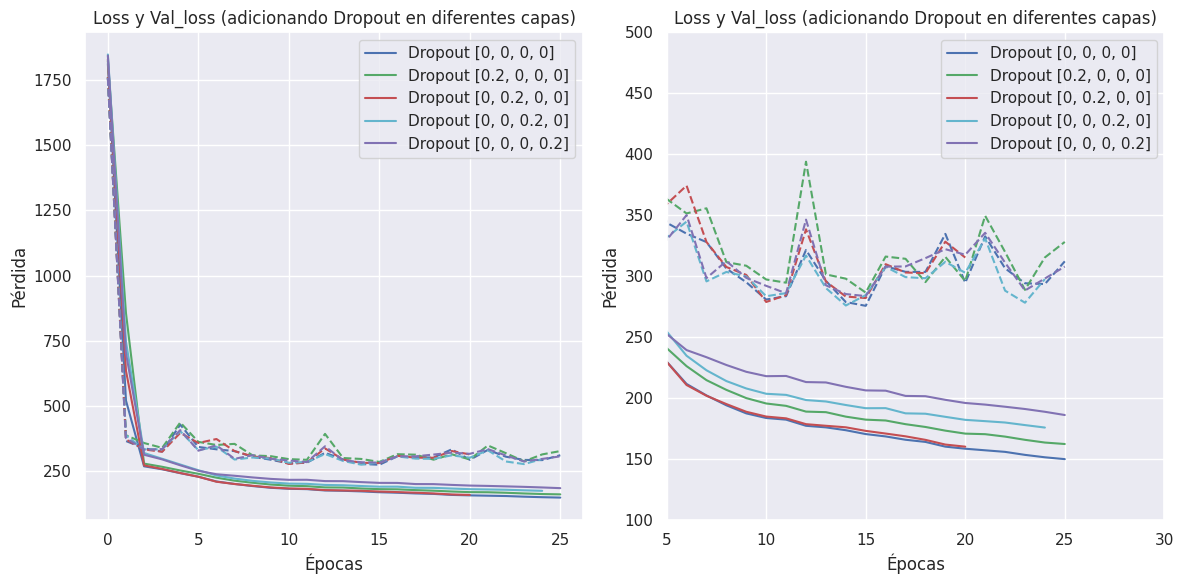

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colores = ["b", "g", "r", "c", "m"]

#Gráfico de loss y val loss vs épocas
for i, (d, loss, val_loss) in enumerate(historia):
    axes[0].plot(loss, label=f"Dropout {d}", color=colores[i])
    axes[0].plot(val_loss, linestyle="--", color=colores[i])

axes[0].set_title("Loss y Val_loss (adicionando Dropout en diferentes capas)")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].legend()

for i, (d, loss, val_loss) in enumerate(historia):
    axes[1].plot(loss, label=f"Dropout {d}", color=colores[i])
    axes[1].plot(val_loss, linestyle="--", color=colores[i])

#Idem con zoom 
axes[1].set_title("Loss y Val_loss (adicionando Dropout en diferentes capas)")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Pérdida")
axes[1].legend()
axes[1].set_xlim(5, 30)
axes[1].set_ylim(100, 500)

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(resultados, columns=["Dropout", "RMSE"])
df

,Dropout,RMSE
0,"[0, 0, 0, 0]",16.599979
1,"[0.2, 0, 0, 0]",16.923843
2,"[0, 0.2, 0, 0]",16.694715
3,"[0, 0, 0.2, 0]",16.607489
4,"[0, 0, 0, 0.2]",16.839584


Después de examinar el impacto de agregar o no la técnica de Dropout a las diversas capas del modelo, se ha concluido que el modelo sin Dropout ha demostrado un rendimiento superior en términos de la métrica de error RMSE.

Ahora bien, antes de proceder a entrenar el modelo final con todos los datos de entrenamiento, es esencial establecer el número óptimo de épocas para el entrenamiento. A lo largo del proceso, hemos aprovechado datos tanto de entrenamiento como de validación, lo cual permitió una evaluación constante en el conjunto de validación. Se han aplicado técnicas como la parada temprana para prevenir el sobreajuste, y también puntos de control (checkpoints) para almacenar los mejores valores obtenidos. En consecuencia, no fue necesario detenernos a deliberar sobre el número de épocas. Sin embargo, al encarar el entrenamiento definitivo solo con los datos de entrenamiento, es imperativo establecer este parámetro de manera precisa.

La siguiente gráfica muestra la pérdida en el conjunto de entrenamiento y validación para el modelo seleccionado:

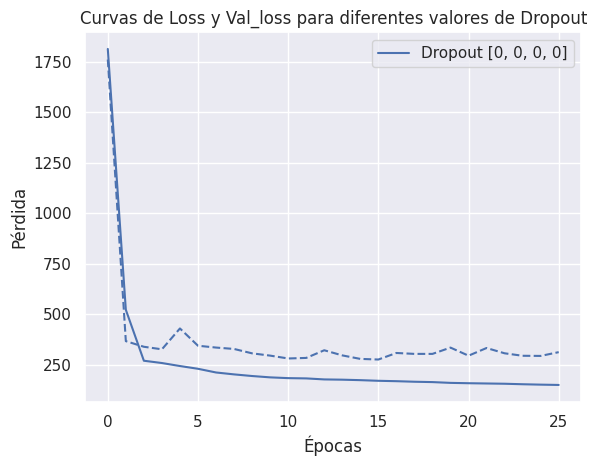

In [ ]:
#loss y val loss vs épocas para el modelo seleccionado
plt.plot(historia[0][1], label=f"Dropout {historia[0][0]}",color="b")
plt.plot(historia[0][2], linestyle="--",color="b")
plt.title("Curvas de Loss y Val_loss para diferentes valores de Dropout")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)

plt.show()

Se observa que:
- El mejor valor en el conjunto de validación se obtuvo con 16 épocas
- A partir de la época 15 se estabiliza bastante la pérdida en el conjunto de entrenamiento y validación
- El entrenamiento se detuvo en la época 25 puesto que el error en el conjunto de validación no mejoró por 10 épocas seguidas.

En este punto, se realizará una validación cruzada repetida utilizando diferentes valores de épocas para determinar cuál de ellos produce mejores resultados. En base a lo anterior, el proceso de validación cruzada se realizará en el rango 10-20. El análisis con CV  permitirá evaluar el rendimiento del modelo con diferentes valores de épocas utilizando diferentes particiones de los datos. El objetivo final es tener una idea más robusta del número óptimo de épocas para entrenar el modelo final.

### ÉPOCAS

In [ ]:
epochs=[10,15,20]

resultados=[]

col_x = list(set(X_train.columns) - set(["unit_num"]))
col_y = ["RUL"]
num_features = len(col_x)
ventana=30

results_folder = "/content/drive/MyDrive/Colab Notebooks/TFM/trial_results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

for ep in epochs:
    #Group shuffle split para separar en train/validation set
    rmse_results=[]
    gss = GroupShuffleSplit(n_splits=3, test_size=0.15, random_state=seed)
    for train_indices, val_idices in gss.split(X_train,y_train,groups=groups):
        X_train_split, X_val_split = X_train.iloc[train_indices],X_train.iloc[val_idices]
        y_train_split, y_val_split =y_train.iloc[train_indices],y_train.iloc[val_idices]

        X_train_array = Crear_Secuencias_X_total(X_train_split, ventana=ventana, columnas=col_x)
        X_val_array = Crear_Secuencias_X_total(X_val_split, ventana=ventana, columnas=col_x)
        y_train_array = Crear_Secuencias_y_total(y_train_split, ventana=ventana, columnas=col_y)
        y_val_array = Crear_Secuencias_y_total(y_val_split, ventana=ventana, columnas=col_y)

    #Modelo
        inputs = Input(shape=(ventana, num_features))
        mask = Masking(mask_value=-99.)(inputs)
        lstm_1 = LSTM(units=128,activation="sigmoid",return_sequences=True)(mask)
        lstm_2=LSTM(units=160,activation="sigmoid",return_sequences=True)(lstm_1)
        lstm_3=LSTM(units=64,activation="sigmoid",return_sequences=False)(lstm_2)
        dense_1=Dense(64)(lstm_3)
        output = Dense(1)(dense_1)

        model = Model(inputs=inputs, outputs=output)

        optimizer = Adam(learning_rate=0.001)
        model.compile(loss="mean_squared_error", optimizer=optimizer)

        #Entrenamiento del Modelo
        history = model.fit(X_train_array, y_train_array,
                        validation_data=(X_val_array, y_val_array),
                        epochs=ep,
                        batch_size=16)

        #Resultados en conjunto de validación
        y_val_pred = model.predict(X_val_array)
        mse = mean_squared_error(y_val_pred, y_val_array)
        rmse = np.sqrt(mse)

        rmse_results.append(rmse)
    resultados.append((ep,rmse_results))
    #Se salvan resultados para poder pausar/reanudar
    results_file = os.path.join(results_folder, f"results_epoch_{ep}.pkl")
    with open(results_file, "wb") as f:
        pickle.dump(resultados, f)


Epoch 1/15
2895/2895 [==============================] - 168s 57ms/step - loss: 1812.7974 - val_loss: 1747.5348
Epoch 2/15
2895/2895 [==============================] - 162s 56ms/step - loss: 669.1026 - val_loss: 382.1853
Epoch 3/15
2895/2895 [==============================] - 163s 56ms/step - loss: 274.6888 - val_loss: 380.3587
Epoch 4/15
2895/2895 [==============================] - 163s 56ms/step - loss: 257.9952 - val_loss: 337.1724
Epoch 5/15
2895/2895 [==============================] - 163s 56ms/step - loss: 241.1918 - val_loss: 369.9288
Epoch 6/15
2895/2895 [==============================] - 163s 56ms/step - loss: 220.6120 - val_loss: 373.3401
Epoch 7/15
2895/2895 [==============================] - 167s 58ms/step - loss: 206.2454 - val_loss: 304.2097
Epoch 8/15
2895/2895 [==============================] - 163s 56ms/step - loss: 198.1582 - val_loss: 308.0994
Epoch 9/15
2895/2895 [==============================] - 163s 56ms/step - loss: 193.4595 - val_loss: 306.9978
Epoch 10/15
2895/

In [ ]:
resultados=[(epocas,np.mean(res)) for epocas, res in resultados]
resultados=pd.DataFrame(resultados,columns=["Épocas", "RMSE"])
resultados

,Épocas,RMSE
0,10,15.900020
1,15,15.457848
2,20,15.580344


En base a los resultados se determinó la utilización de 15 épocas.

### MODELO FINAL

**CREACIÓN DE SECUENCIAS**  
Se crean las secuencias para entrenar el modelo con todos los datos de entrenamiento

In [12]:
ventana=30
col_x = sorted(list(set(X_train.columns) - set(["unit_num"])))
col_y = ["RUL"]
num_features=len(col_x)

X_train_array = Crear_Secuencias_X_total(X_train, ventana=ventana, columnas=col_x)
y_train_array = Crear_Secuencias_y_total(y_train, ventana=ventana, columnas=col_y)

print(f"X_train_array shape {X_train_array.shape}")
print(f"y_train_array shape {y_train_array.shape}")

X_train_array shape (54028, 30, 22)
y_train_array shape (54028, 1)


De igual forma se crean las secuencias para el conjunto de prueba

In [13]:
X_test_array=(list(Crear_Secuencias_X_test(X_test[X_test["unit_num"]==i],ventana,col_x,-99))for i in X_test["unit_num"].unique())
X_test_array=np.concatenate(list(X_test_array)).astype(np.float32)
print(f"X_test_array shape: {X_test_array.shape}")

y_test_array=y_test.values
print(f"y_test_array shape: {y_test_array.shape}")

X_test_array shape: (248, 30, 22)
y_test_array shape: (248, 1)


**ENTRENAMIENTO MODELO FINAL**

In [ ]:
#Modelo
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(units=128,activation="sigmoid",return_sequences=True)(mask)
lstm_2=LSTM(units=160,activation="sigmoid",return_sequences=True)(lstm_1)
lstm_3=LSTM(units=64,activation="sigmoid",return_sequences=False)(lstm_2)
dense_1=Dense(64)(lstm_3)
output = Dense(1)(dense_1)

model = Model(inputs=inputs, outputs=output)

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

#Train
history = model.fit(X_train_array, y_train_array,
                    epochs=15,
                    batch_size=16)

Epoch 1/15
3377/3377 [==============================] - 200s 57ms/step - loss: 1825.3470
Epoch 2/15
3377/3377 [==============================] - 197s 58ms/step - loss: 1043.6803
Epoch 3/15
3377/3377 [==============================] - 193s 57ms/step - loss: 291.1783
Epoch 4/15
3377/3377 [==============================] - 194s 57ms/step - loss: 258.5523
Epoch 5/15
3377/3377 [==============================] - 195s 58ms/step - loss: 236.4330
Epoch 6/15
3377/3377 [==============================] - 199s 59ms/step - loss: 221.1880
Epoch 7/15
3377/3377 [==============================] - 207s 61ms/step - loss: 212.4502
Epoch 8/15
3377/3377 [==============================] - 210s 62ms/step - loss: 205.7889
Epoch 9/15
3377/3377 [==============================] - 211s 62ms/step - loss: 200.3703
Epoch 10/15
3377/3377 [==============================] - 211s 63ms/step - loss: 197.8648
Epoch 11/15
3377/3377 [==============================] - 215s 64ms/step - loss: 195.2833
Epoch 12/15
3377/3377 [=====

**EVALUACIÓN EN DATOS DE ENTRENAMIENTO Y PRUEBA**

In [ ]:
y_train_pred = model.predict(X_train_array)
mse = mean_squared_error(y_train_pred, y_train_array)
rmse = np.sqrt(mse)
print(f"RMSE Train {rmse.round(2)}")

y_test_pred = model.predict(X_test_array)
mse = mean_squared_error(y_test_pred, y_test_array)
rmse = np.sqrt(mse)
print(f"RMSE Test {rmse.round(2)}")

1689/1689 [==============================] - 50s 30ms/step
RMSE Train 13.470000267028809
8/8 [==============================] - 0s 29ms/step
RMSE Test 26.44


Los resultados obtenidos reflejan mejoras sustanciales en el rendimiento del modelo. El error se redujo en aproximadamente un 10% en comparación con la fase anterior, disminuyendo el RMSE de 29.67 a 26.44. Estos resultados resaltan la innata capacidad de las redes neuronales recurrentes para capturar de manera efectiva los patrones temporales presentes en los datos.

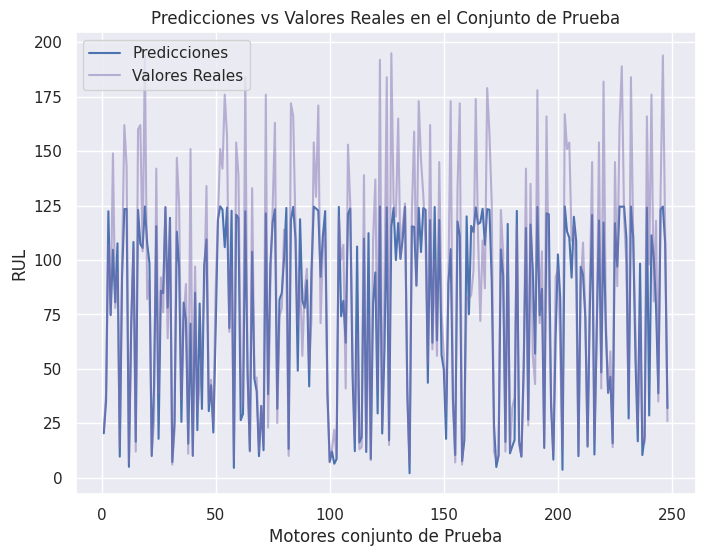

In [ ]:
plt.figure(figsize=(8, 6))

indices = np.arange(1, len(y_test_array) + 1)
plt.plot(indices, y_test_pred, label="Predicciones",color="b")
plt.plot(indices, y_test_array, label="Valores Reales", color="m",alpha=0.5)
plt.xlabel("Motores conjunto de Prueba")
plt.ylabel("RUL")
plt.title("Predicciones vs Valores Reales en el Conjunto de Prueba")
plt.legend()
plt.grid(True)

Después de graficar las predicciones del modelo frente a los valores reales en el conjunto de prueba, se puede observar que el modelo muestra un desempeño muy bueno en la predicción de RULs inferiores a 125. Esto coincide con el fenómeno esperado debido a la aplicación de la técnica de "RUL clipping". Con esto, el modelo se ha centrado en la predicción de valores de RUL críticos, es decir, aquellos motores que están experimentando una degradación significativa y están más cerca de alcanzar el final de su vida útil. La precisión en la predicción de valores más comprometedores es de suma importancia, ya que es donde se requiere una predicción más precisa y crítica para tomar decisiones operativas adecuadas, como planificar mantenimientos y evitar fallas inesperadas.

En conclusión, el análisis gráfico muestra que el modelo es excepcionalmente bueno en la predicción de RUL para valores inferiores a 125, lo que refuerza la eficacia de la técnica de RUL clipping y confirma que el modelo se desempeña de manera óptima en situaciones críticas de degradación en motores.

**GUARDAR MODELO Y EL SCALER PARA LA FASE DE PRODUCTIVIZACIÓN**

In [ ]:
ruta_guardado = "/content/drive/MyDrive/Colab Notebooks/TFM/ModeloFinal.h5"
save_model(model, ruta_guardado)

In [16]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num

y_train=X_train[["unit_num","RUL"]]
X_train=X_train.drop(labels=["RUL","cycle"],axis=1)

#Test
X_test=test.drop(labels=["cycle"],axis=1)#no saco "unit_num"  para implementar la generación de secuencias por unidad (motor)


#Se crea variable condición operativa
X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                        X_train["setting_2"].astype(str) + "_" + \
                        X_train["setting_3"].astype(str)

X_test["condición_op"] = X_test["setting_1"].astype(str) + "_" + \
                        X_test["setting_2"].astype(str) + "_" + \
                        X_test["setting_3"].astype(str)


#Escalado por condición operativa

scalers_dict = {} # PARA GUARDAR ESCALADO

for cond in X_train["condición_op"].unique():
    filtro=X_train[X_train["condición_op"]==cond]
    filtro_test=X_test[X_test["condición_op"]==cond]

    scaler = MinMaxScaler()
    scaler.fit(filtro[sensor])
    X_train.loc[X_train["condición_op"]==cond, sensor]=scaler.transform(filtro[sensor])
    X_test.loc[X_test["condición_op"]==cond, sensor]=scaler.transform(filtro_test[sensor])

    scalers_dict[cond] = scaler #GUARDAR ESCALADO


In [18]:
with open("/content/drive/MyDrive/Colab Notebooks/TFM/scalers_dict.pkl", "wb") as scaler_file:
    pickle.dump(scalers_dict, scaler_file)

In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 13px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))